# Let's make a center of people's face image regression

In [10]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the CPU


In [1]:
#hide
!pip install -Uqq fastbook
from fastai.imports import *
import fastbook
from fastbook import *
fastbook.setup_book()

# FASTAI / FASTBOOK DOESN'T SUPPORT torchvision >=0.8 therefore can't use gpu

ERROR: Could not find a version that satisfies the requirement torchvision>=0.8 (from fastai>=2.1->fastbook) (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.3.0, 0.4.1, 0.5.0)
ERROR: No matching distribution found for torchvision>=0.8 (from fastai>=2.1->fastbook)


NameError: name 'log_args' is not defined

In [21]:
# dataset from oreil.ly/wHL28
path = untar_data(URLs.BIWI_HEAD_POSE)

NameError: name 'untar_data' is not defined

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

In [9]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
# Function to get the center point of face for each data as c1,c1 coordinate
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])


In [10]:
# Create our datablock
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
               Normalize.from_stats(*imagenet_stats)])

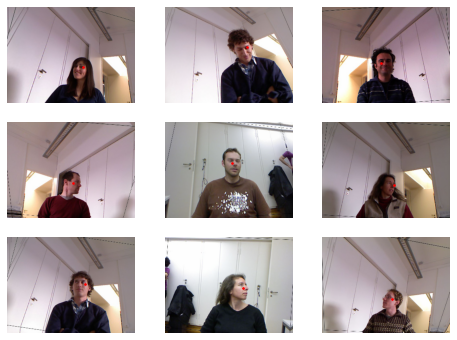

In [11]:
# Show few examples
dls = biwi.dataloaders(path, num_workers=0)
dls.show_batch(max_n=9, figsize=(8,6))

In [12]:
xb,yb = dls.one_batch()
xb.shape, yb.shape 
# xb- independent var, 64 samples of size 240x320 with 3 rgb color i think
# yb- dependent var, 64 samples, 1 tensor of coordinate, what is 2 idk

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

## We are using Convolutional Neural Network with resnet18 architect

In [13]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1)) # model with scale
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi+lo) + lo #activision function
#dls.loss_func # We are using FlattenedLoss of MSELoss()

AttributeError: 'Learner' object has no attribute 'to'

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=2.2908675418875646e-06)

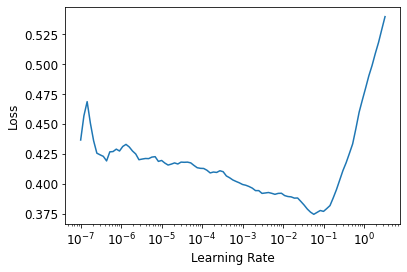

In [17]:
learn.lr_find()

In [18]:
# Looks like lr = e^-2 looks great or like just before lr = e^-1
#lr = between 1/100 and 1/10 but closer to 1/10 
lr = 0.1
learn.fit_one_cycle(5, lr)

KeyboardInterrupt: 

In [ ]:
custom_photos = [PILImage.create("image/face"),PILImage.create("image/masked"),PILImage.create("image/hanbok")]
learn.predict(custom_photos)